In [1]:
#from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import OrderedDict, Counter
#%matplotlib nbagg
%load_ext autoreload

plt.rcParams['nbagg.transparent'] = False
plt.rcParams['figure.facecolor'] = 'w'

import pymultinest

/home/hope-moloko/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:914: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  mplDeprecation)


In [2]:
def new_func(x_1,a):
    return a*np.exp(-0.5*(x_1)**2)

In [3]:
def the_function(x, a_cub, b_cub, c_cub):
    return a_cub*x*np.sin(b_cub*x +c_cub)

In [4]:
def another_function(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

Text(0,0.5,'$Y$')

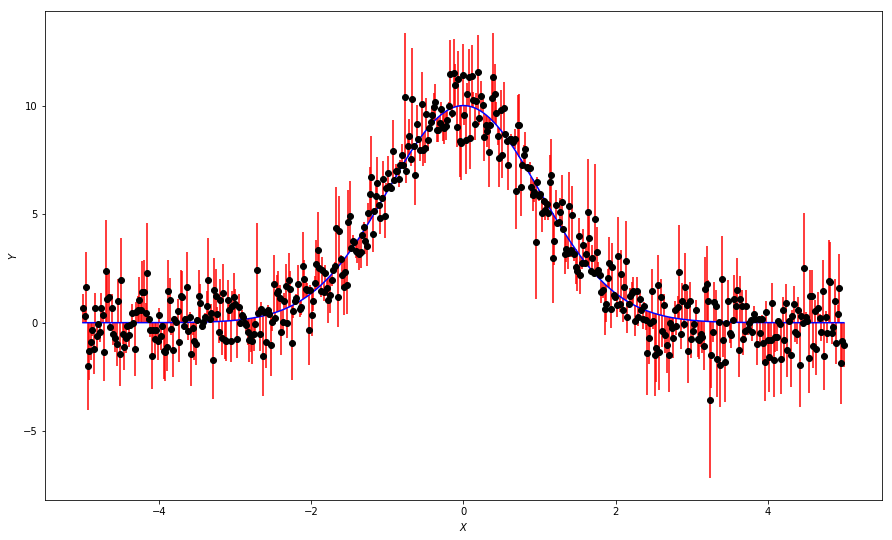

In [5]:

a_true = 10.0

# generate mock data

x_1 = np.linspace(-5,5,500)

yerr_1 = np.random.normal(0,1.0,len(x_1))

y_true_1 = new_func(x_1,a_true)

y_dat_1 = y_true_1 + yerr_1

dat11 = np.column_stack((x_1, y_dat_1, yerr_1))

# plot results
plt.figure(figsize=(15, 9))
plt.errorbar(x_1, y_dat_1, yerr=yerr_1, fmt='ko', ecolor='red')
plt.plot(x_1, y_true_1,c='blue')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')

Text(0,0.5,'y')

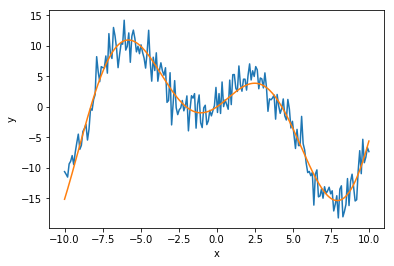

In [6]:
a_cub = 2
b_cub = 0.5
c_cub = 1

true_params1 = [a_cub,b_cub,c_cub]
sig = 2
x = np.linspace(-10, 10, 200)
y_true = the_function(x, a_cub,b_cub,c_cub)
err = abs(np.random.randn(len(x))*0.1 + 1)*sig
y = np.random.randn(len(x))*err + y_true

dat1 = np.column_stack((x, y, err))

plt.figure()
plt.plot(x,y)
plt.plot(x,y_true)
plt.xlabel('x')
plt.ylabel('y')

Text(0,0.5,'y')

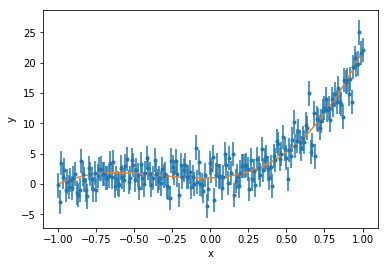

In [7]:
a = 10
b = 10
c = 1
d = 1


true_params = [a,b,c, d]
sig = 2
x = np.linspace(-1, 1, 200)
y_true = another_function(x, a,b,c, d)
err = abs(np.random.randn(len(x))*0.1 + 1)*sig
y = np.random.randn(len(x))*err + y_true

dat = np.column_stack((x, y, err))

plt.figure()
plt.errorbar(x,y, yerr=sig, 
             linestyle='none', marker='.')
plt.plot(x,y_true)
plt.xlabel('x')
plt.ylabel('y')

In [8]:
dat1 = np.loadtxt('example_data-Copy1.txt')

In [9]:
#np.savetxt('example_cubic_data.txt', dat)
dat = np.loadtxt('example_cubic_data-Copy1.txt')

In [10]:
class FitData:
    """
    Encapsulated class for fitting some HI profile data
    """
    def __init__(self, dat, func, bounds=[]):       

        if len(bounds) == 0:
            self.bounds = OrderedDict([
                    ('a', [0, 5]),
                    ('b', [0, 2]),
                    ('c', [0, 2])
                     #('d', [0, 2])
#                     ('e', [0, 1])
                ])
        else:
            self.bounds = bounds

        self.dat = dat
        self.func = func
        self.ndim = len(self.bounds)
    
    def loglike(self, cube, ndim, nparams):
        p = np.zeros(ndim)
        for i in range(ndim):
            p[i] = cube[i]
            
        y_fit = self.func(self.dat[:,0], *p) 
        chi2 = np.sum(((dat[:,1] - y_fit)/dat[:,2])**2)
        return -0.5*chi2
    
    def prior(self, cube, ndim, nparams):
        """
        Prior for multinest

        Parameters
        ----------
        cube : array-like
            Input parameter cube
        ndim : int
            Number of dimensions
        nparams : int
            Number of parameters actually varying

        Returns
        -------
        array
            Transformed parameter cube

        """
        keys = list(self.bounds.keys())
        for i in range(ndim):
            lower = self.bounds[keys[i]][0]
            upper = self.bounds[keys[i]][1]
            cube[i] = cube[i]*(upper-lower)+lower
            
        return cube
    
    def fit(self, chain_name='chain', n_live_points=500, multimodal=True):

        t1 = time.time()
        
        pymultinest.run(self.loglike, self.prior, self.ndim, importance_nested_sampling = True, init_MPI = False,
                        resume = False, verbose = False, sampling_efficiency = 'parameter', 
                        n_live_points = n_live_points, outputfiles_basename = chain_name, multimodal = multimodal)
        print('Time taken', time.time()-t1)
        

In [11]:
fd = FitData(dat, the_function)
#fd = FitData(dat, another_function)

In [12]:
fd.fit(n_live_points=500)

Time taken 7.054237365722656


In [13]:
chain = np.loadtxt('chainpost_equal_weights.dat')

<Figure size 432x288 with 0 Axes>

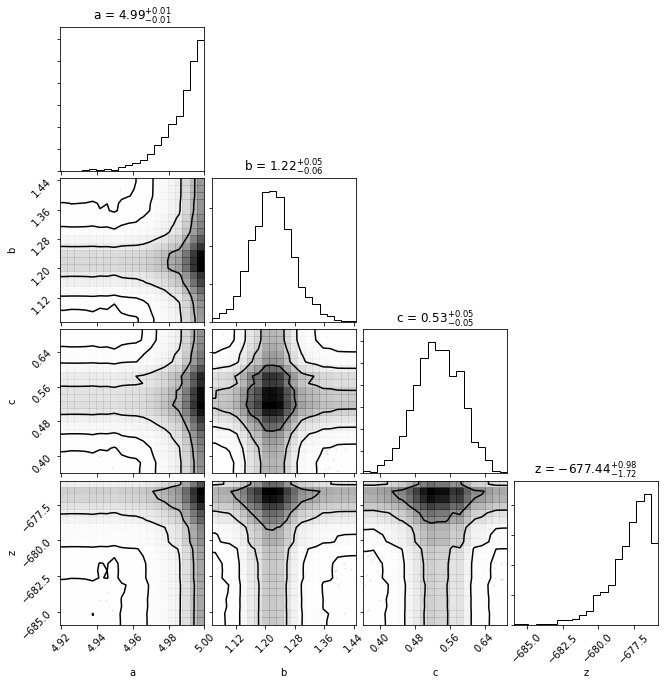

In [15]:
import corner


plt.figure()
corner.corner(chain,labels=['a','b','c','z'],show_titles=True, true_vals=true_params, smooth=2.4e3);

In [64]:
fd1 = FitData(dat1, the_function,bounds=OrderedDict([
                    ('a', [0, 3]),
                    ('b', [0, 1]),
                    ('c', [0, 2])]))

In [65]:
fd1.fit(chain_name='chains_cub')

Time taken 5.273887872695923


In [66]:
chain2 = np.loadtxt('chains_cubpost_equal_weights.dat')

In [67]:
chain2.shape

(2305, 4)

<Figure size 432x288 with 0 Axes>

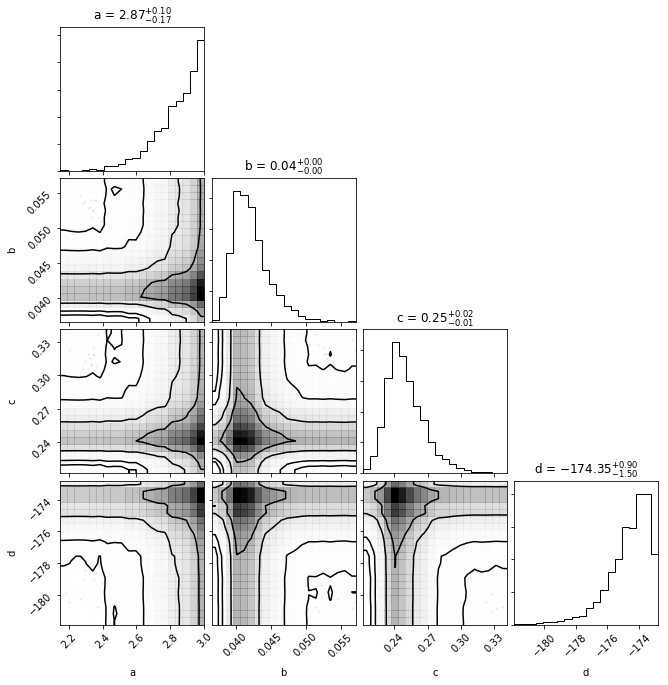

In [68]:
plt.figure()
corner.corner(chain2,labels=['a','b','c','d','z'],show_titles=True, true_vals=true_params, smooth=2.4e3);

In [76]:
fd_new = FitData(dat11, new_func,bounds=OrderedDict([
                    ('a', [0, 15])]))